# Analyse du referendum 2013
Nous allons analyser les résultats du referendum2013 en deux etapes :
* Analyse de la base du référendum 2013
* Analyse prédictive en utilisant des bases de données de l'INSEE

In [1]:
library("readxl")
library("maptools")
library("fBasics")
library("plotly")
library("reshape")
library("corrplot")

library("Hmisc")
library("ggpubr")

library(rgdal)
library(rgeos)
library(maptools)
library(gpclib) 

library(rpart)
library(hydroGOF)

Loading required package: sp
Checking rgeos availability: TRUE
Loading required package: timeDate
Loading required package: timeSeries


Rmetrics Package fBasics
Analysing Markets and calculating Basic Statistics
Copyright (C) 2005-2014 Rmetrics Association Zurich
Educational Software for Financial Engineering and Computational Science
Rmetrics is free software and comes with ABSOLUTELY NO WARRANTY.
https://www.rmetrics.org --- Mail to: info@rmetrics.org
Loading required package: ggplot2

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:timeSeries’:

    filter

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout


Attaching package: ‘reshape’

The following object is masked from ‘package:plotly’:

    rename

Loading required package: lattice
Loading required package: survival
Loading required package: Formula

## Analyse de la base du referendum2013
### Obtenir les données
Importer (load) la base de données 'Referendum.csv'

In [2]:
dat = read.csv("Referendum.csv", header = TRUE, sep = ";")

#### Quelles variables sont disponibles dans la base ?

In [3]:
names(dat)

[1] "Code.du.département"    "Libellé.du.département" "Code.de.la.commune"    
[4] "Libellé.de.la.commune"  "Inscrits"               "Abstentions"           
[7] "Blancs.et.nuls"         "Choix.A"                "Choix.B"

#### Description des variables

En regardant les noms des attributs de la base et étant donné qu'il s'agit d'une base de données d'un référendum en France, on peut faire une description rapide des variables et de leur relations (et possibles questions par rapport à leur nature) :
* **Code.du.département** : variable catégorielle //
* **Libellé.du.département** : variable catégorielle  // Cette variable et **Code.du.département** devraient être parfaitement corrélées
* **Code.de.la.commune** : variable catégorielle // Les communes de chaque département sont énumerées 1,2,... ?
* **Libellé.de.la.commune** : variable catégorielle // Cette variable et **Code.de.la.commune** sont parfaitement corrélées. Prendre en compte la réponse à la dernière question.
* **Inscrits** : variable numérique // tous les inscrits sur la liste éléctoral // ce n'est pas l'équivalent des majeurs de 18 ans qui habitent dans la commune : il peut y avoir des votants qui habitent dans la commune et qui ne sont pas inscrits et des inscrits qui n'habitent plus dans la commune // On devrait avoir **Inscrits** = **Abstentions** + **Blancs.et.nuls** + **Choix.A** + **Choix.B** 
* **Abstentions** : variable numérique // le nombre d'inscrits qui n'ont pas voté 
* **Blancs.et.nuls** : variable numérique //
* **Choix.A** : variable numérique //
* **Choix.B** : variable numérique //

#### Quelques informations initiales sur la base :

* Attributs Catégoriels ?
    * Variables catégorielles : **Code.du.département**, **Libellé.du.département**, **Code.de.la.commune**, **Libellé.de.la.commune**

* Attributs Numériques ?
    * Variables numériques : **Inscrits**, **Abstentions**, **Blancs.et.nuls**, **Choix.A**, **Choix.B**

* Data type ? 
    * Strings : 2 
    * Integers : 7 
    
* Attributs avec des fautes (coquilles/typos) ?
    * Pas de fautes trouvées //
Cette question peut être dificile dans une base de données de grande taille. Nous pouvons prendre des échantillons de la base et trouver des erreurs qu'il faudrait corriger // On a utilisé unique() pour avoir une liste des modalités des variables categorielles
    
* Attributs avec des NaN ou vide ?
    * Non 

In [4]:
#preview de la base
dat[1:5,]

Code.du.département Libellé.du.département Code.de.la.commune
1 1                   AIN                    1                 
2 1                   AIN                    2                 
3 1                   AIN                    4                 
4 1                   AIN                    5                 
5 1                   AIN                    6                 
  Libellé.de.la.commune   Inscrits Abstentions Blancs.et.nuls Choix.A Choix.B
1 L'Abergement-Clémenciat  592       84          9             154     345   
2 L'Abergement-de-Varey    215       36          5              66     108   
3 Ambérieu-en-Bugey       8205     1698        126            2717    3664   
4 Ambérieux-en-Dombes     1152      170         18             280     684   
5 Ambléon                  105       17          1              35      52

In [5]:
#Data types et résumé des variables
sapply(dat,class)
summary(dat)
#changer le code de la commune d'integer à factor
dat$Code.de.la.commune = as.factor(dat$Code.de.la.commune)

Code.du.département Libellé.du.département     Code.de.la.commune 
              "factor"               "factor"              "integer" 
 Libellé.de.la.commune               Inscrits            Abstentions 
              "factor"              "integer"              "integer" 
        Blancs.et.nuls                Choix.A                Choix.B 
             "integer"              "integer"              "integer"

 Code.du.département    Libellé.du.département Code.de.la.commune
 62     :  895       PAS DE CALAIS :  895      Min.   :  1.0     
 2      :  816       AISNE         :  816      1st Qu.:105.0     
 80     :  782       SOMME         :  782      Median :218.0     
 76     :  744       SEINE MARITIME:  744      Mean   :251.7     
 57     :  730       MOSELLE       :  730      3rd Qu.:361.0     
 14     :  706       CALVADOS      :  706      Max.   :909.0     
 (Other):32118       (Other)       :32118                        
    Libellé.de.la.commune    Inscrits        Abstentions      
 Sainte-Colombe:   14     Min.   :      6   Min.   :     0.0  
 Saint-Sauveur :   12     1st Qu.:    160   1st Qu.:    23.0  
 Beaulieu      :   11     Median :    337   Median :    49.0  
 Saint-Sulpice :   11     Mean   :   1251   Mean   :   256.7  
 Sainte-Marie  :   11     3rd Qu.:    807   3rd Qu.:   120.0  
 Beaumont      :   10     Max.   :1253322   Max.   :248755.0  
 (Other)       :36722          

#### Distribution des variables catégorielles ?
* Départements : Il y a 107 modalités pour la variable **Code.du.département** et 107 modalités pour la variable **Libellé.du.département**
* Communes : Il y a 908 modalités pour la variable **Code.de.la.commune** et 34237 modalités pour la variable **Libellé.de.la.commune** // L'incohérence s'explique par la répétition des codes des communes dans chaque départament

In [6]:
describe(dat[,1:5])

dat[, 1:5] 

 5  Variables      36791  Observations
--------------------------------------------------------------------------------
Code.du.département 
       n  missing distinct 
   36791        0      107 

lowest : 1  10 11 12 13, highest: ZP ZS ZW ZX ZZ
--------------------------------------------------------------------------------
Libellé.du.département 
       n  missing distinct 
   36791        0      107 

lowest : AIN                     AISNE                   ALLIER                  ALPES DE HAUTE PROVENCE ALPES MARITIMES        
highest: VIENNE                  VOSGES                  WALLIS-ET-FUTUNA        YONNE                   YVELINES               
--------------------------------------------------------------------------------
Code.de.la.commune 
       n  missing distinct 
   36791        0      908 

lowest : 1   2   3   4   5  , highest: 905 906 907 908 909
--------------------------------------------------------------------------------
Libellé.de.la.commune 

## Analyse de la base par variable
Le résultat le plus important qu'on peut obtenir est le gagnant de l'élection. Egalement, nous voulons surtout trouver les variables qui peuvent prédire le nombre de voix pour l'option A ou B. Cependant, nous pouvons aussi faire des observations sur le nombre d'inscrits, des voix blancs ou même créer des nouvelles variables et les inclure dans notre analyse.

In [7]:
sprintf("Choix A a %.2f%% de voix, soit %1.0f voix d un total de %1.0f votes valides", 
        sum(dat$Choix.A)/(sum(dat$Choix.A)+sum(dat$Choix.B))*100, sum(dat$Choix.A),
        (sum(dat$Choix.A)+sum(dat$Choix.B)))
sprintf("Choix B a %.2f%% de voix, soit %1.0f voix d un total de %1.0f votes valides", 
        sum(dat$Choix.B)/(sum(dat$Choix.A)+sum(dat$Choix.B))*100, sum(dat$Choix.B),
        (sum(dat$Choix.A)+sum(dat$Choix.B)))

[1] "Choix A a 43.75% de voix, soit 15699580 voix d un total de 35883209 votes valides"

[1] "Choix B a 56.25% de voix, soit 20183629 voix d un total de 35883209 votes valides"

Nous faisons des barplots pour voir les communes les plus peuplées et les moins peuplées par rapport aux Choix A et B. Nous pouvons observer la grande difference de population entre les communes les plus peuplées et les communes avec peu d'habitants. Cette difference suggère la nécessité d'une transformation des variables (normalisation).

Using Libellé.de.la.commune as id variables


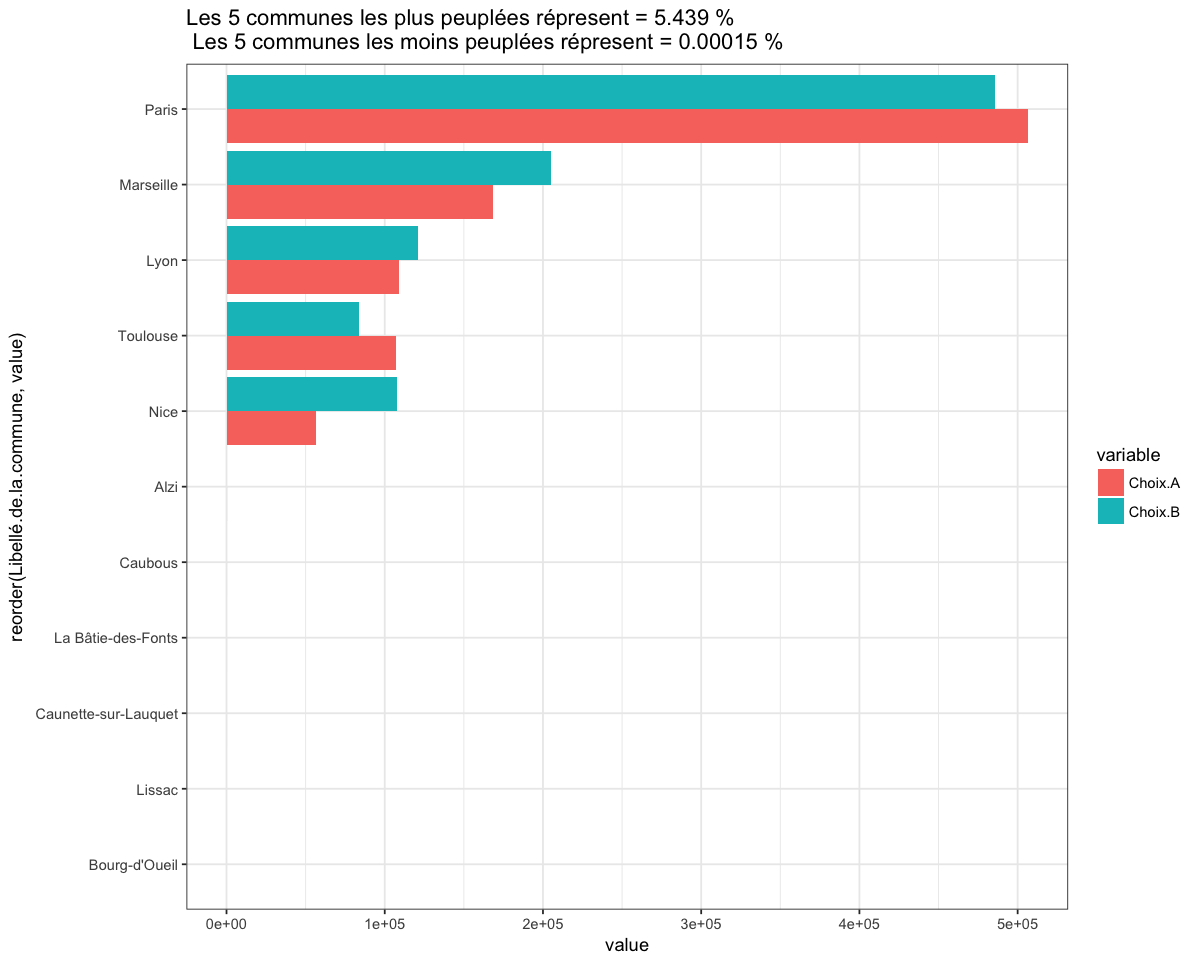

In [27]:
dat.ordered <- dat[order(dat$Choix.B,decreasing = T),]
dat.ordered.plot <-dat.ordered[,c("Libellé.de.la.commune","Choix.A","Choix.B")]
until = 5
last = 5
dat.ordered.plot.long <- melt(dat.ordered.plot[c(1:until,(nrow(dat.ordered.plot)-last):nrow(dat.ordered.plot)),])

pc = sum(dat.ordered$Valides[1:until])/sum(dat.ordered$Valides)*100
pclast = sum(dat.ordered$Valides[(nrow(dat.ordered.plot)-last):nrow(dat.ordered.plot)])/sum(dat.ordered$Valides)*100

p <- ggplot(data = dat.ordered.plot.long,aes(x=reorder(Libellé.de.la.commune,value), y=value,fill=variable))
p    + theme_bw() + geom_bar(stat="identity",position="dodge") + coord_flip() + 
ggtitle(sprintf("Les %.0f communes les plus peuplées répresent = %.3f %% \n Les %.0f communes les moins peuplées répresent = %.5f %%",until,pc,last,pclast))

### Création des variables
Nous pourrons faire simultanément une analyse au niveau des communes et au niveau des départements, mais étant donné la quantité des communes (>30k), la variance entre les populations des communes et le temps l'analyse, nous allons nous concentrer sur les départements. Nous allons créer alors des variables au niveau des départements.
* **Valides** : somme des votes pour le Choix A et le Choix B
* **Exprimes** : toutes les voix exprimées, Choix A + Choix B + Blancs et nuls
* **Abstentions.pc** : pourcentage d'Abstentions par rapport au niveau géographique
* **Blancs.et.nuls.pc** : pourcentage de Blancs et Nuls par rapport au niveau géographique
* **Choix.A.pc** : pourcentage de voix pour le Choix A par rapport au niveau géographique
* **Choix.B.pc** : pourcentage de voix pour le Choix B par rapport au niveau géographique
* **dat.dep** : fichier avec les variables au niveau des départements

In [9]:
dat = read.csv("dat.csv")
dat.dep = read.csv("dat_dep.csv")

In [10]:
#Statistiques basiques
#abstentions à niveau National
print("Summary % Abstentions (commune/departement)")
summary(dat$Abstentions.pc)
summary(dat.dep$Abstentions.pc)
#Blancs et nuls 
print("Summary % Blancs et nuls (commune/departement)")
summary(dat$Blancs.et.nuls.pc)
summary(dat.dep$Blancs.et.nuls.pc)
#Choix A
print("Summary % Choix A.pc (commune/departement)")
summary(dat$Choix.A.pc)
summary(dat.dep$Choix.A.pc)
#Choix B
print("Summary % Choix B.pc (commune/departement)")
summary(dat$Choix.B.pc)
summary(dat.dep$Choix.B.pc)
dat[dat$Valides==0,]

[1] "Summary % Abstentions (commune/departement)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   12.24   14.82   15.43   17.85   83.89 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13.86   16.69   17.94   21.05   20.15   63.51 

[1] "Summary % Blancs et nuls (commune/departement)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.299   1.875   2.034   2.557 100.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.605   1.787   1.945   2.134   2.178   7.877 

[1] "Summary % Choix A.pc (commune/departement)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   32.08   38.94   39.46   46.27  100.00       3 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30.83   39.93   43.05   43.95   47.87   65.56 

[1] "Summary % Choix B.pc (commune/departement)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   53.73   61.06   60.54   67.92  100.00       3 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  34.44   52.13   56.95   56.05   60.07   69.17 

X     Code.du.département Libellé.du.département Code.de.la.commune
3520   3520 10                  AUBE                   298               
11953 11953 31                  HAUTE GARONNE           81               
16835 16835 43                  HAUTE LOIRE            122               
      Libellé.de.la.commune Inscrits Abstentions Blancs.et.nuls Choix.A Choix.B
3520  Pont-sur-Seine        719      172         547            0       0      
11953 Bourg-d'Oueil          21        1          20            0       0      
16835 Lissac                236       27         209            0       0      
      Valides Exprimes Abstentions.pc Blancs.et.nuls.pc Choix.A.pc Choix.B.pc
3520  0       547      23.922114      100               NA         NA        
11953 0        20       4.761905      100               NA         NA        
16835 0       209      11.440678      100               NA         NA

## Les autres bases de données

Importer (load) les autres bases de données :
* filo-revenu-pauvrete-menage-2013 : Fichier Localisé Social et Fiscal (FiLoSoFi) - Année 2013 
    * revenu-departemens.xls
* base-cc-evol-struct-pop-2013 : Chiffres clés - Évolution et structure de la population
    * pop.xls

### Quelles variables choisir ?
Nous choisisons quelques variables de chaque base de données aditionnelle
* revenu-departements:
    * MED13 ; Médiane du niveau vie
    * RD13 ; Rapport inter-décile 9e décile/1er decile
    * TP6013 ; Taux de pauvreté-Ensemble
    * TP60AGE513 ; Taux de pauvreté-60 à 74 ans
    
* pop:
    * P13_POP ; Population
    * P13_POPH ; Nombre total d'hommes
    * P13_POP0014 ; Nombre de personnes 0-14 ans en 2013
    * P13_POP1529 ; Nombre de personnes 15-29 ans en 2013
    * P13_POP3044 ; Nombre de personnes 30-44 ans en 2013
    * P13_POP4559 ; Nombre de personnes 45-59 ans en 2013
    * P13_POP6074 ; Nombre de personnes 60-74 ans en 2013
    * P13_POP7589 ; Nombre de personnes 75-89 ans en 2013
    * P13_POP90P ; Nombre de personnes 90 ans ou plus en 2013
    * C13_POP15P_CS1 ; Nombre de personnes de 15 ans ou plus Agriculteurs exploitants
    * C13_POP15P_CS3 ; Nombre de personnes de 15 ans ou plus Cadres et Professions intellectuelles supérieures
    
Nous allons utiliser des variables normalisées ou pourcentages pour eviter les problemes liés à l'échelle des variables.

In [11]:
dat.dep = read.csv("dat_dep2.csv")
chosen = c("Choix.A.pc","Choix.B.pc","Abstentions.pc","Blancs.et.nuls.pc","P13_POPH.pc",
                   "P13_POP0014.pc","P13_POP1529.pc","P13_POP3044.pc","P13_POP4559.pc",
                   "P13_POP6074.pc","P13_POP7589.pc","P13_POP90P.pc","C13_POP15P_CS1.pc",
                  "C13_POP15P_CS3.pc","MED13.n","RD13.n","TP6013","TP60AGE513")
summary(dat.dep[,chosen])

   Choix.A.pc      Choix.B.pc    Abstentions.pc  Blancs.et.nuls.pc
 Min.   :30.83   Min.   :40.69   Min.   :13.86   Min.   :1.204    
 1st Qu.:39.78   1st Qu.:52.81   1st Qu.:16.49   1st Qu.:1.784    
 Median :42.87   Median :57.13   Median :17.71   Median :1.904    
 Mean   :43.28   Mean   :56.72   Mean   :18.02   Mean   :1.946    
 3rd Qu.:47.19   3rd Qu.:60.22   3rd Qu.:19.38   3rd Qu.:2.098    
 Max.   :59.31   Max.   :69.17   Max.   :26.54   Max.   :2.658    
  P13_POPH.pc    P13_POP0014.pc  P13_POP1529.pc  P13_POP3044.pc 
 Min.   :47.05   Min.   :14.00   Min.   :12.64   Min.   :15.62  
 1st Qu.:48.21   1st Qu.:16.47   1st Qu.:14.70   1st Qu.:17.67  
 Median :48.58   Median :17.68   Median :16.36   Median :18.59  
 Mean   :48.56   Mean   :17.77   Mean   :16.64   Mean   :18.76  
 3rd Qu.:48.87   3rd Qu.:18.85   3rd Qu.:18.48   3rd Qu.:19.56  
 Max.   :49.84   Max.   :22.49   Max.   :23.42   Max.   :23.23  
 P13_POP4559.pc  P13_POP6074.pc  P13_POP7589.pc   P13_POP90P.pc   
 Min.   :

### Corrélation
Nous allons maintenant voir la corrélation entre variables. Notez bien que toutes les variables considérées sont numeriques. On peut donc calculer la correlation linéaire sans souci.

[1] "X"                      "Departements"           "Libelle.de.departement"
 [4] "Inscrits"               "Valides"                "Exprimes"              
 [7] "Abstentions"            "Blancs.et.nuls"         "Choix.A"               
[10] "Choix.B"                "Abstentions.pc"         "Blancs.et.nuls.pc"     
[13] "Choix.A.pc"             "Choix.B.pc"             "P13_POPH.pc"           
[16] "P13_POP0014.pc"         "P13_POP1529.pc"         "P13_POP3044.pc"        
[19] "P13_POP4559.pc"         "P13_POP6074.pc"         "P13_POP7589.pc"        
[22] "P13_POP90P.pc"          "C13_POP15P_CS1.pc"      "C13_POP15P_CS3.pc"     
[25] "MED13"                  "RD13"                   "TP6013"                
[28] "TP60AGE513"             "P13_POP"                "MED13.n"               
[31] "RD13.n"

Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"addcolorlabel" n'est pas un paramètre graphique”Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"addcolorlabel" n'est pas un paramètre graphique”Warning message in title(title, ...):
“"addcolorlabel" n'est pas un paramètre graphique”

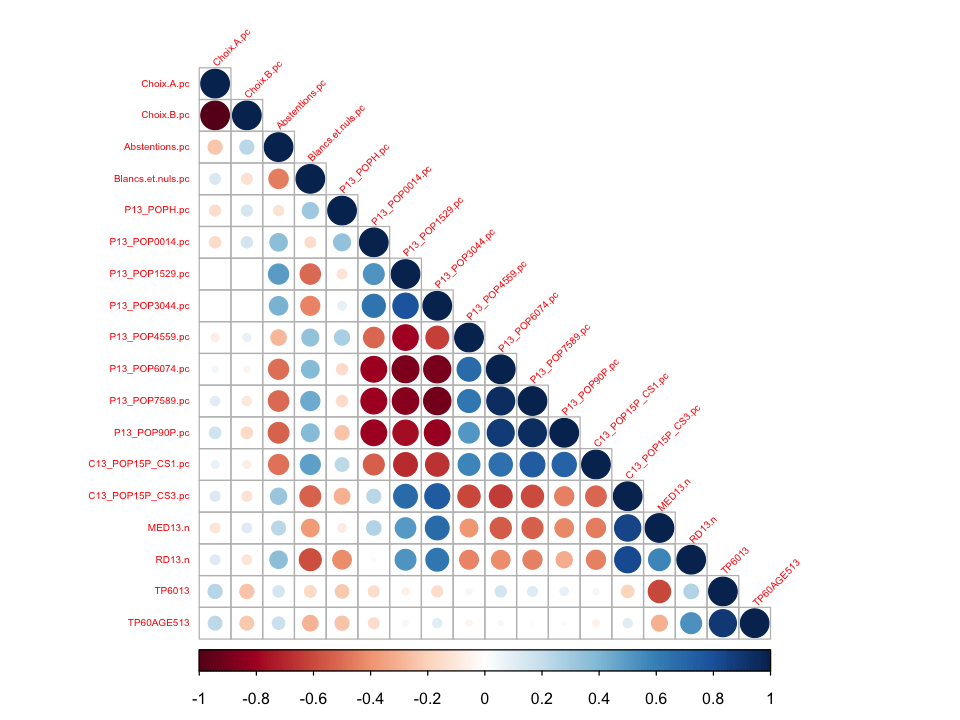

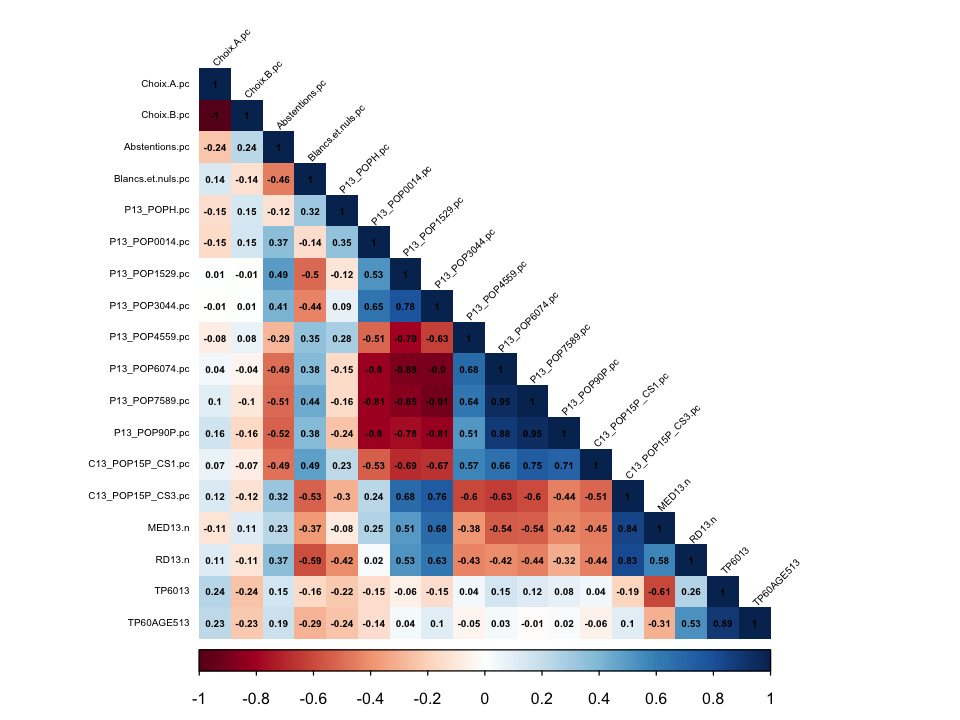

In [12]:
C = cor(dat.dep[,chosen], use = "complete.obs")
names(dat.dep)
options(repr.plot.width=8, repr.plot.height=6)
corrplot(C, type="lower",number.cex = 0.4,tl.srt=45, tl.cex = 0.5) #, order="hclust"
corrplot(C, type="lower", method="shade", shade.col=NA, tl.col="black", tl.srt=45, 
         addCoef.col="black", addcolorlabel="no",number.cex = 0.5, tl.cex = 0.5)



### Visualisation
A partir du calcul des correlations, nous pouvons faire des hyphothèses sur la relation entre variables

#### Observations
* La variable Choix A (et par consequent Choix B) n'ont pas de fortes corrélations avec les autres variables analysées. Les corrélations les plus fortes sont liées à l'**Abstentions.pc** (-0.24) et au **TP6013** (0.24). 
* Les variables **Abstentions.pc** et **Blancs.et.nuls.pc** présentent des correlations plus fortes. Par exemple :
    * **Abstentions.pc** a une corrélation de -0.52 avec la variable **P13_POP90P.pc**
    * **Blancs.et.nuls.pc** a une corrélation de -0.59 avec la variable **RD13.n**
* Quelques relations probables entre variables peuvent être observées :
    * Le taux de pauvreté **TP6013** est corrélé negativement avec la mediane de vie **MD13.n** (-0.61)
    * Le porcentage des cadres **C13_POP15P_CS3** est corrélé positivement avec la mediane de vie **MD13.n** (0.84)

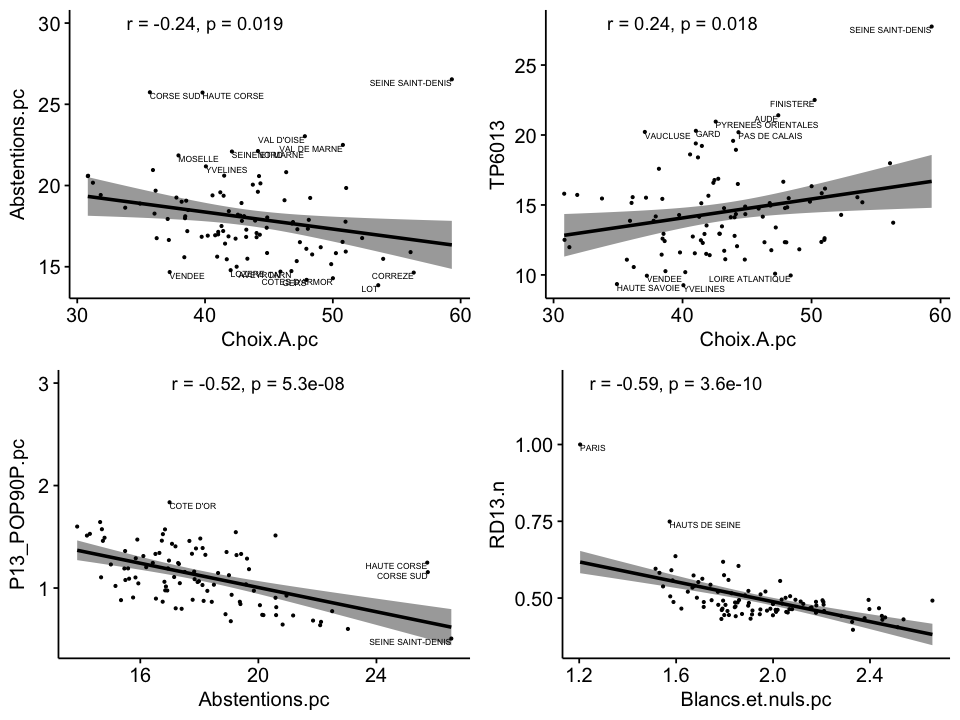

In [13]:
ChoixA.Abstentions.pc <- ggscatter(dat.dep, x = "Choix.A.pc", y = "Abstentions.pc",
                add = "reg.line",
                conf.int = TRUE, size = 0.5
                ) + 
geom_text(aes(label=ifelse(Abstentions.pc>21 | Abstentions.pc<15,as.character(Libelle.de.departement),'')),
                              hjust="inward", vjust=1,size=1.8) + 
stat_cor(label.x = 40, label.y = 30)

ChoixA.TP6013  <- ggscatter(dat.dep, x = "Choix.A.pc", y = "TP6013",
                add = "reg.line",
                conf.int = TRUE, size = 0.5
                ) + 
geom_text(aes(label=ifelse(TP6013>20 | TP6013<10,as.character(Libelle.de.departement),'')),
                              hjust="inward", vjust=1,size=1.8) +
stat_cor(label.x = 40, label.y = 28)

Abstentions.pc.P13_POP90P.pc  <- ggscatter(dat.dep, x = "Abstentions.pc", y = "P13_POP90P.pc",
                add = "reg.line",
                conf.int = TRUE, size = 0.5
                ) + 
geom_text(aes(label=ifelse(P13_POP90P.pc>1.8 | Abstentions.pc>24,as.character(Libelle.de.departement),'')),
                              hjust="inward", vjust=1,size=1.8) +
stat_cor(label.x = 20, label.y = 3)

Blancs.et.nuls.pc.RD13.n  <- ggscatter(dat.dep, x = "Blancs.et.nuls.pc", y = "RD13.n",
                add = "reg.line",
                conf.int = TRUE, size = 0.5
                ) + 
geom_text(aes(label=ifelse(Blancs.et.nuls.pc<1.5 | RD13.n>0.7,as.character(Libelle.de.departement),'')),
                              hjust="inward", vjust=1,size=1.8) +
stat_cor(label.x = 1.6, label.y = 1.2)

ggarrange(ChoixA.Abstentions.pc, ChoixA.TP6013, 
          Abstentions.pc.P13_POP90P.pc, Blancs.et.nuls.pc.RD13.n,
          ncol = 2, nrow = 2)

#### Correlation géographique
Nous pouvons faire des cartes des départaments français pour voir s'il existe une relation géographique avec les voix. 
* Les départaments nord-est votent plus pour le **ChoixB**
* Les départements sud-ouest votent plus pour le **Choix A**
* Notez bien que de toutes façons le Choix B gagne dans presque tous les départements
* Nous observons une division géographique similaire pour les **Abstentions** et les **Blancs.et.nuls** :
    * Les départements du nord-est ont des taux d'**Abstentions** plus grand que les départements sud-ouest
    * Les départements sud-ouest ont des taux de **Blancs.et.nuls** plus grand que les départements nord-est

Warning message:
“use rgdal::readOGR or sf::st_read”Warning message:
“use rgdal::readOGR or sf::st_read”

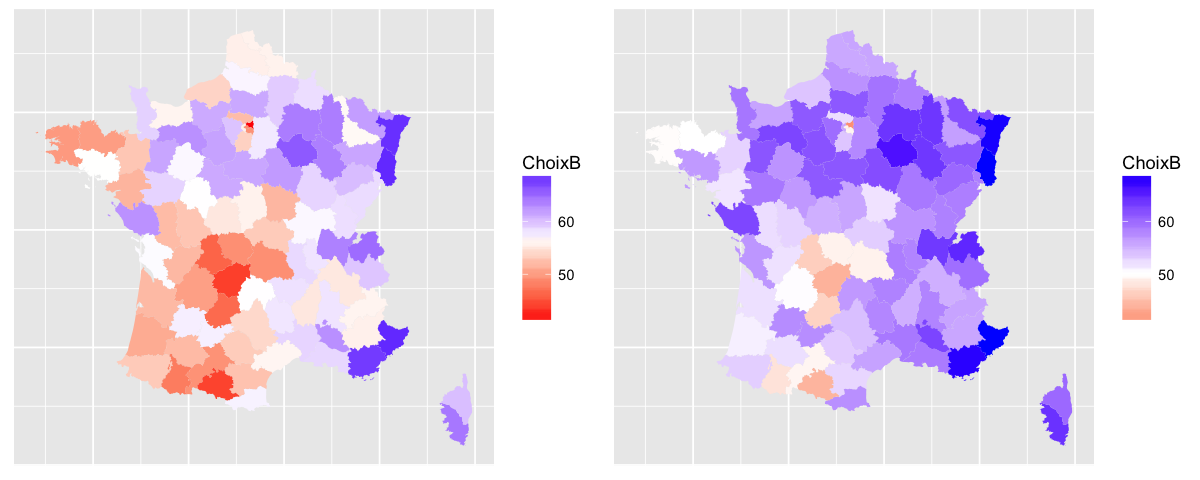

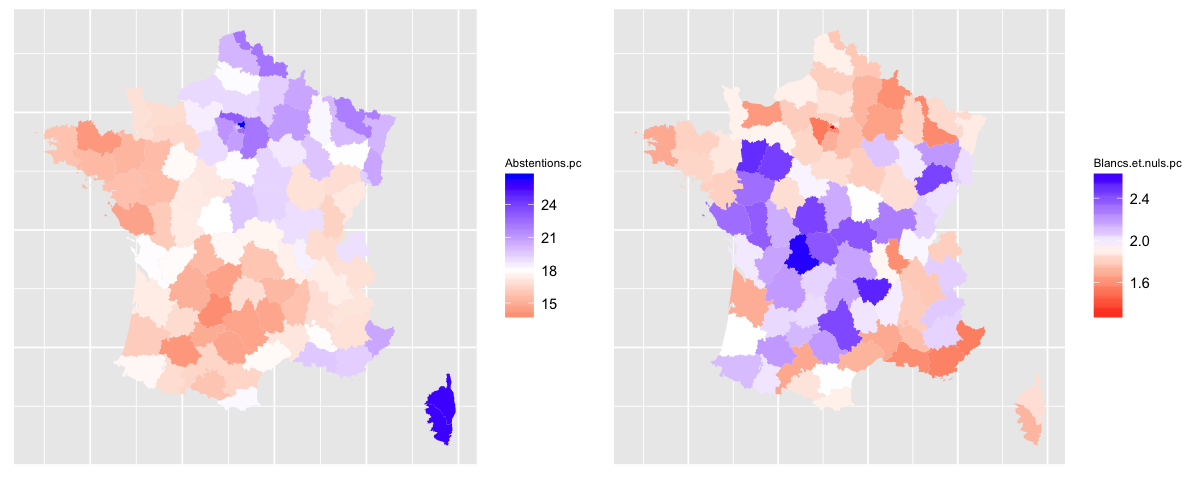

In [14]:
departements<-readShapeSpatial("./map/GEOFLA_1-1_SHP_LAMB93_FR-ED131/GEOFLA/DEPARTEMENT.SHP")

levels(departements$CODE_DEPT)[levels(departements$CODE_DEPT)=="01"] <- "1"
levels(departements$CODE_DEPT)[levels(departements$CODE_DEPT)=="02"] <- "2"
levels(departements$CODE_DEPT)[levels(departements$CODE_DEPT)=="03"] <- "3"
levels(departements$CODE_DEPT)[levels(departements$CODE_DEPT)=="04"] <- "4"
levels(departements$CODE_DEPT)[levels(departements$CODE_DEPT)=="05"] <- "5"
levels(departements$CODE_DEPT)[levels(departements$CODE_DEPT)=="06"] <- "6"
levels(departements$CODE_DEPT)[levels(departements$CODE_DEPT)=="07"] <- "7"
levels(departements$CODE_DEPT)[levels(departements$CODE_DEPT)=="08"] <- "8"
levels(departements$CODE_DEPT)[levels(departements$CODE_DEPT)=="09"] <- "9"

departements.ggplot = fortify(departements,region = "CODE_DEPT")
ChoixA = dat.dep$Choix.A.pc
ChoixB = dat.dep$Choix.B.pc
Abstentions = dat.dep$Abstentions.pc
Blancs.et.nuls = dat.dep$Blancs.et.nuls.pc
options(repr.plot.width=10, repr.plot.height=4)
carteA = ggplot() + geom_map(data = dat.dep, aes(map_id = Departements,
                                       fill = ChoixB),
                   map = departements.ggplot) + 
expand_limits(x = departements.ggplot$long, y = departements.ggplot$lat)+
scale_fill_gradient2(low = "red", 
    mid = "white", midpoint = mean(ChoixB),
                     high = "blue", limits = c(min(ChoixB), max(ChoixB)))+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
       axis.title.y=element_blank(),
       axis.text.y=element_blank(),
       axis.ticks.y=element_blank())

carteB = ggplot() + geom_map(data = dat.dep, aes(map_id = Departements,
                                       fill = ChoixB),
                   map = departements.ggplot) + 
expand_limits(x = departements.ggplot$long, y = departements.ggplot$lat)+
scale_fill_gradient2(low = "red", 
    mid = "white", midpoint = 50, #= mean(ChoixB),
                     high = "blue", limits = c(min(ChoixB), max(ChoixB)))+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
       axis.title.y=element_blank(),
       axis.text.y=element_blank(),
       axis.ticks.y=element_blank())

carteAbstentions = ggplot() + geom_map(data = dat.dep, aes(map_id = Departements,
                                       fill = Abstentions.pc),
                   map = departements.ggplot) + 
expand_limits(x = departements.ggplot$long, y = departements.ggplot$lat)+
scale_fill_gradient2(low = "red", 
    mid = "white", midpoint = mean(Abstentions),
                     high = "blue", limits = c(min(Abstentions), max(Abstentions)))+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
       axis.title.y=element_blank(),
       axis.text.y=element_blank(),
       axis.ticks.y=element_blank(),
       legend.title = element_text(size = 7))

carteBlancs = ggplot() + geom_map(data = dat.dep, aes(map_id = Departements,
                                       fill = Blancs.et.nuls.pc),
                   map = departements.ggplot) + 
expand_limits(x = departements.ggplot$long, y = departements.ggplot$lat)+
scale_fill_gradient2(low = "red", 
    mid = "white", midpoint = mean(Blancs.et.nuls),
                     high = "blue", limits = c(min(Blancs.et.nuls), max(Blancs.et.nuls)))+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
       axis.title.y=element_blank(),
       axis.text.y=element_blank(),
       axis.ticks.y=element_blank(),
       legend.title = element_text(size = 7))

ggarrange(carteA, carteB, 
          ncol = 2, nrow = 1)
ggarrange(carteAbstentions, carteBlancs, 
          ncol = 2, nrow = 1)

## Analyses prédictives
Supposons que nous voulons prédire le gagnant de l'election (ou les Abstentions ou Blancs et nuls). Nous devons donc utiliser des méthodes des *classification et regression*. Nous choisisons la variable **Choix.A.pc** comme la variable dépendante ou variable réponse. 

Nous allons diviser la base de données en 2 groupes : *train* et *test*. Avec le groupe *train*  nous allons entrainer nos algorithmes et avec le groupe *test* nous allons prédire les valeurs de la variable dépendante (pourcentage de voix pour le Choix A dans notre cas). Alors, nous devons utiliser des méthodes de classification et regression, dans le contexte du *Supervised Learning*. Nous choisons deux méthodes classiques et nous allons finalement comparer les erreurs de chaque méthodes pour choisir la plus adapté pour notre problème. 
* Régression linéaire
* Classification Tree

### Regression linéaire 
Nous faisons une regression linéaire pour la variable **Choix.A.pc** avec les variables indépendantes :  

* **Abstentions.pc**
* **Blancs.et.nuls.pc**
* **P13_POPH.pc**
* **P13_POP0014.pc**
* **P13_POP1529.pc **
* **P13_POP3044.pc**
* **P13_POP4559.pc**
* **P13_POP6074.pc**
* **P13_POP7589.pc**
* **C13_POP15P_CS1.pc**
* **MED13.n**
* **RD13.n**
* **TP6013**
* **TP60AGE513**


In [15]:
#train = sample(1:nrow(dat.dep),nrow(dat.dep)*(2/3),replace=F)
#train = sort(train)
load("train_vector.Rdata")
chosen_linear = c("Abstentions.pc","Blancs.et.nuls.pc","P13_POPH.pc",
                   "P13_POP0014.pc","P13_POP1529.pc","P13_POP3044.pc","P13_POP4559.pc",
                   "P13_POP6074.pc","P13_POP7589.pc","C13_POP15P_CS1.pc",
                  "MED13.n","RD13.n","TP6013","TP60AGE513")

x_train <- dat.dep[train,chosen_linear]
y_train <- dat.dep[train,"Choix.A.pc"]
x_test <- dat.dep[-train,chosen_linear]
y_test <- dat.dep[-train,"Choix.A.pc"]
x <- cbind(x_train,y_train)
# Train the model using the training sets and check score
linear <- lm(y_train ~ ., data = x)
summary(linear)
#Predict Output
predicted_linear = predict(linear,x_test) 

[1]  1  3  4  6  7  9 11 14 16 17 18 19 20 22 23 24 26 27 29 31 32 35 37 38 41
[26] 42 44 45 48 49 53 55 56 57 59 62 64 65 66 67 68 69 70 71 72 73 75 76 77 79
[51] 81 82 83 84 85 86 87 89 90 92 93 94 95 96


Call:
lm(formula = y_train ~ ., data = x)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.698  -3.402  -1.115   3.549  10.223 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)  
(Intercept)       2264.0921  1221.5876   1.853   0.0699 .
Abstentions.pc      -0.8663     0.4292  -2.018   0.0490 *
Blancs.et.nuls.pc    8.1792     4.0127   2.038   0.0469 *
P13_POPH.pc         -0.7829     3.2230  -0.243   0.8091  
P13_POP0014.pc     -23.5892    12.6678  -1.862   0.0686 .
P13_POP1529.pc     -22.1937    12.5203  -1.773   0.0825 .
P13_POP3044.pc     -20.8456    12.7019  -1.641   0.1072  
P13_POP4559.pc     -22.3918    12.2094  -1.834   0.0727 .
P13_POP6074.pc     -23.8750    12.3667  -1.931   0.0593 .
P13_POP7589.pc     -24.4697    14.7692  -1.657   0.1039  
C13_POP15P_CS1.pc   -1.1700     2.1769  -0.537   0.5934  
MED13.n             70.4309    63.0351   1.117   0.2693  
RD13.n             -42.0593    47.4389  -0.887   0.3796  
TP6013               3.1232     1.37

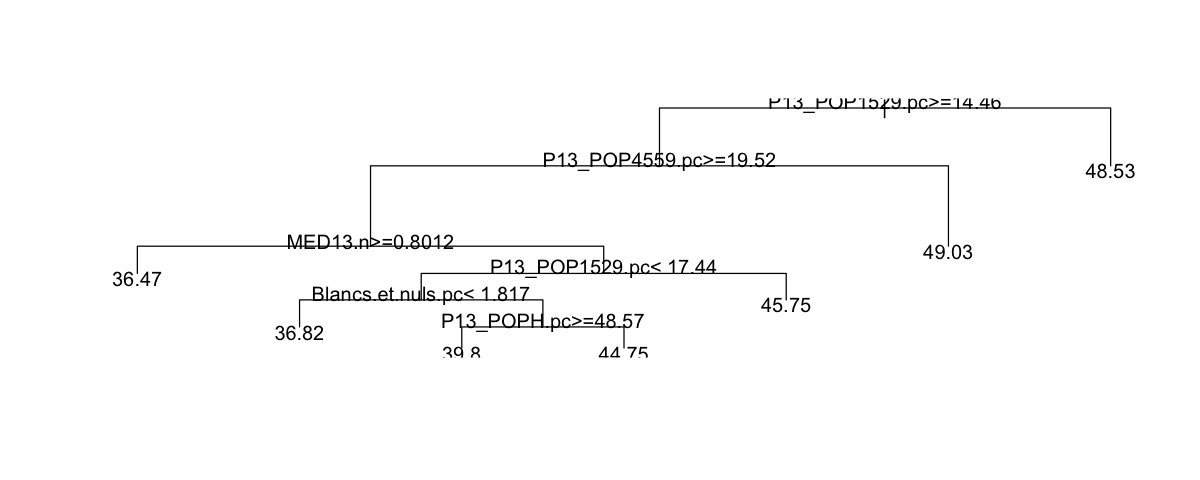

In [16]:
#save(train,file = "train_vector.Rdata")
#load("train_vector.Rdata")

rpart.model <- rpart(y_train ~ .,data = x, method = "anova")
#summary(rpart.model)
plot(rpart.model)
text(rpart.model)

predicted_tree <- predict(rpart.model, x_test)

In [26]:
data.frame("Test" = y_test, "Linear_prediction" = predicted_linear, 
           "Tree_prediction" = predicted_tree)
errors = data.frame("Error_Linear_prediction" = mse(y_test,predicted_linear),
                    "Error_Tree_prediction" = mse(y_test,predicted_tree))
errors

Test     Linear_prediction Tree_prediction
2  40.58347 43.92452          36.82211       
5  44.03240 47.82838          39.79899       
8  41.49657 38.61064          36.82211       
10 33.75343 45.06042          44.74914       
12 45.89875 45.90139          48.52961       
13 41.19475 44.90876          45.75386       
15 43.21688 40.84523          48.52961       
21 39.80143 26.26052          48.52961       
25 49.87250 44.83448          39.79899       
28 38.67344 34.01904          36.82211       
30 50.24015 46.69284          36.82211       
33 47.94308 42.92745          48.52961       
34 48.04520 47.39620          45.75386       
36 47.17318 44.12224          49.03113       
39 44.82403 39.78374          36.47171       
40 41.56646 42.21948          39.79899       
43 41.28843 42.96626          49.03113       
46 38.45048 42.39581          39.79899       
47 53.55308 43.50124          48.52961       
50 40.94933 48.04464          49.03113       
51 40.79261 36.65608          39.79899       
52 35.92379 39.54578          45.75386       
54 38.37857 43.61630          39.79899       
58 37.91953 35.16181          45.75386       
60 44.13737 44.19241          49.03113       
61 38.52522 40.37024          45.75386       
63 44.33361 49.08339          45.75386       
74 40.21142 42.43486          36.47171       
78 42.10248 41.24466          36.47171       
80 47.92729 45.02218          39.79899       
88 53.93895 55.55266          44.74914       
91 41.45323 44.78766          45.75386

Error_Linear_prediction Error_Tree_prediction
1 24.17845                40.00234

### Peut-on améliorer les modéles ?
Quand on a un modéle avec beaucoup des variables indépendants, une maniere de reduire cette quantité est en utilisant des techniques de *reduction de dimensionalité*. Nous allons donc faire un PCA pour réduires les dimensionalité et après utiliser le PCA pour faire une regression sur la variable **Choix.A.pc**.

#### PCA


In [18]:
prin_comp <- prcomp(x_train, scale. = T)

In [19]:
prin_comp$rotation

PC1         PC2          PC3         PC4         PC5         
Abstentions.pc     0.23356680  0.142692401 -0.15938598  0.04833251  0.835048962
Blancs.et.nuls.pc -0.22779533 -0.243702276 -0.22755943  0.20315485 -0.085904957
P13_POPH.pc       -0.04891292 -0.384034621 -0.47519142 -0.45428906  0.003834114
P13_POP0014.pc     0.24350367 -0.238234666 -0.42138536  0.15005984 -0.054078916
P13_POP1529.pc     0.34156131  0.006832111  0.01892941  0.15431958 -0.086400738
P13_POP3044.pc     0.35265776 -0.075061460 -0.05439685 -0.24258227 -0.168953415
P13_POP4559.pc    -0.30288036 -0.074452954 -0.04936747 -0.41720985  0.408879696
P13_POP6074.pc    -0.35280046  0.125028570  0.16975640  0.02191024  0.070826415
P13_POP7589.pc    -0.35337965  0.129025963  0.18687594  0.02976148  0.042058364
C13_POP15P_CS1.pc -0.30955565 -0.011123749 -0.06497847 -0.37894295 -0.216098839
MED13.n            0.27105541 -0.182893646  0.40228756 -0.35199215  0.054381604
RD13.n             0.27452007  0.287135155  0.21709977 -0.39227002 -0.095340346
TP6013            -0.04209995  0.519730489 -0.39047764  0.01544416 -0.083550221
TP60AGE513         0.05767526  0.535131334 -0.29031600 -0.21861953 -0.129110863
                  PC6          PC7         PC8         PC9         PC10       
Abstentions.pc     0.094207126 -0.30574226  0.27338208 -0.11425231 -0.07635914
Blancs.et.nuls.pc  0.851588224 -0.21179241 -0.06576321  0.04795958  0.09122016
P13_POPH.pc       -0.177077052 -0.13471463 -0.17846419 -0.51095168  0.20671986
P13_POP0014.pc    -0.058626402  0.40862873  0.46482902  0.26735823  0.25832440
P13_POP1529.pc    -0.148402490 -0.52132727 -0.42684944  0.20622046  0.17966816
P13_POP3044.pc     0.208522905  0.07972716 -0.01630275 -0.12667795 -0.66686593
P13_POP4559.pc     0.043613412  0.28839080 -0.40904888  0.51923562 -0.05714872
P13_POP6074.pc     0.013633701  0.14405945  0.04463488 -0.43163041  0.19186321
P13_POP7589.pc     0.030497727 -0.05349403  0.19793601 -0.10305945 -0.05817224
C13_POP15P_CS1.pc -0.141990016 -0.52652850  0.48595680  0.33235239 -0.08763710
MED13.n            0.182753774  0.06041530  0.18345516  0.04291948  0.30349958
RD13.n             0.295750440  0.00544991  0.02741119 -0.03882991  0.37441295
TP6013            -0.009835179  0.01184944 -0.10458072  0.09367106  0.28549485
TP60AGE513         0.146563286  0.10278748  0.02378003 -0.06637877 -0.18559809
                  PC11         PC12        PC13         PC14        
Abstentions.pc     0.028599443  0.05679590  0.004173465 -0.001494597
Blancs.et.nuls.pc  0.039446727 -0.03444974 -0.022667189  0.004737436
P13_POPH.pc       -0.153375521 -0.08554057  0.043614871  0.004774996
P13_POP0014.pc     0.035492389 -0.01054340  0.130737438 -0.371196052
P13_POP1529.pc     0.111886711 -0.15057307  0.023911230 -0.514854572
P13_POP3044.pc    -0.060786711  0.32351464 -0.208977679 -0.341698635
P13_POP4559.pc     0.040235624  0.02615763  0.044742663 -0.171660755
P13_POP6074.pc     0.548254114  0.20199942 -0.130611753 -0.470204922
P13_POP7589.pc    -0.684644367 -0.24148058  0.090144873 -0.478273279
C13_POP15P_CS1.pc  0.198409140  0.13293009 -0.027165671 -0.008515316
MED13.n           -0.009948444 -0.34607629 -0.565513029  0.007495933
RD13.n            -0.104773564  0.34070691  0.524477374 -0.004104187
TP6013            -0.260980500  0.31483393 -0.546959259  0.023756438
TP60AGE513         0.259105655 -0.63904887  0.119413100 -0.017818525

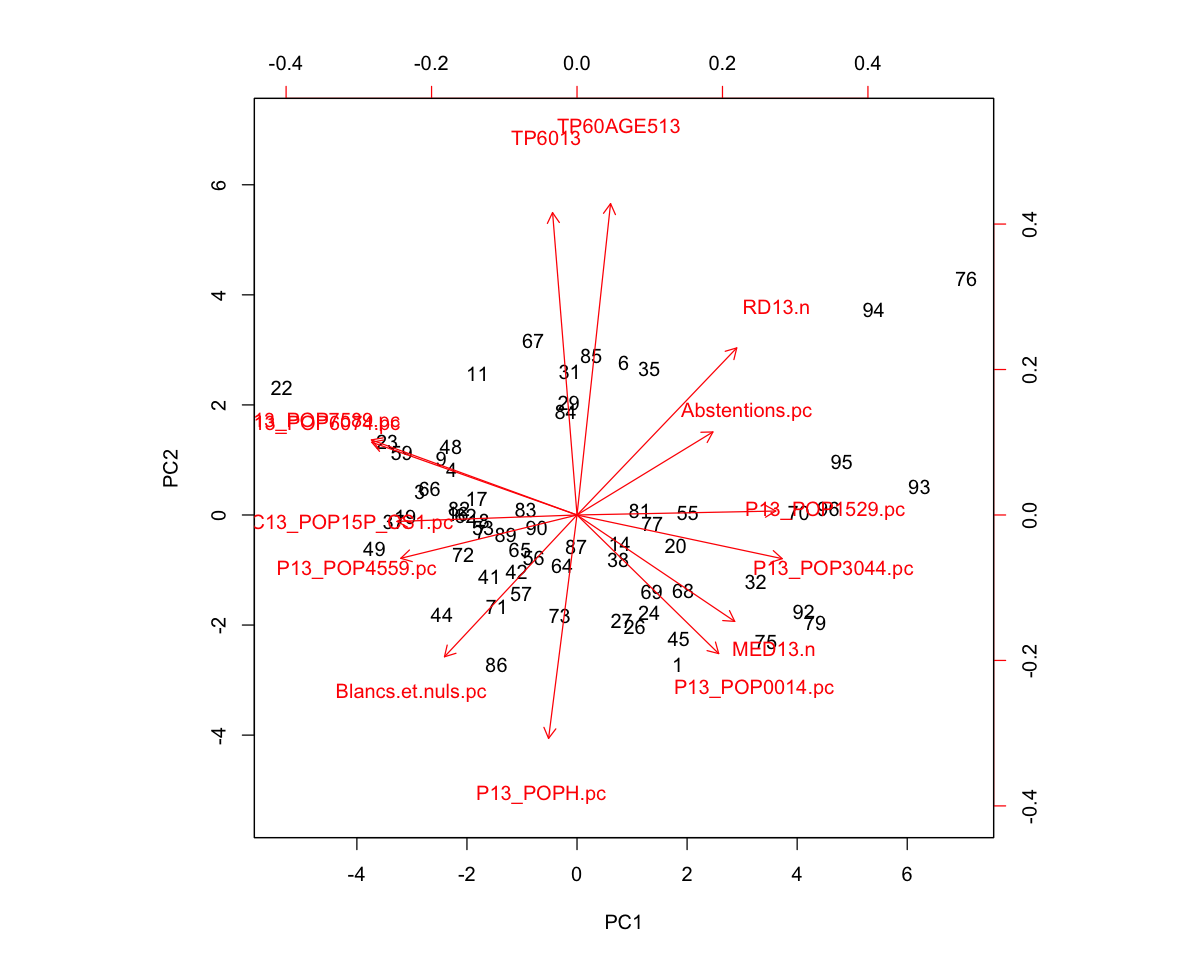

In [20]:
options(repr.plot.width=10, repr.plot.height=8)
biplot(prin_comp, scale = 0)

[1] 4.957178e-01 1.889416e-01 1.180285e-01 5.529403e-02 4.755486e-02
 [6] 3.351962e-02 2.922302e-02 1.456299e-02 7.760009e-03 3.833783e-03
[11] 2.572920e-03 2.211010e-03 7.694915e-04 1.032229e-05

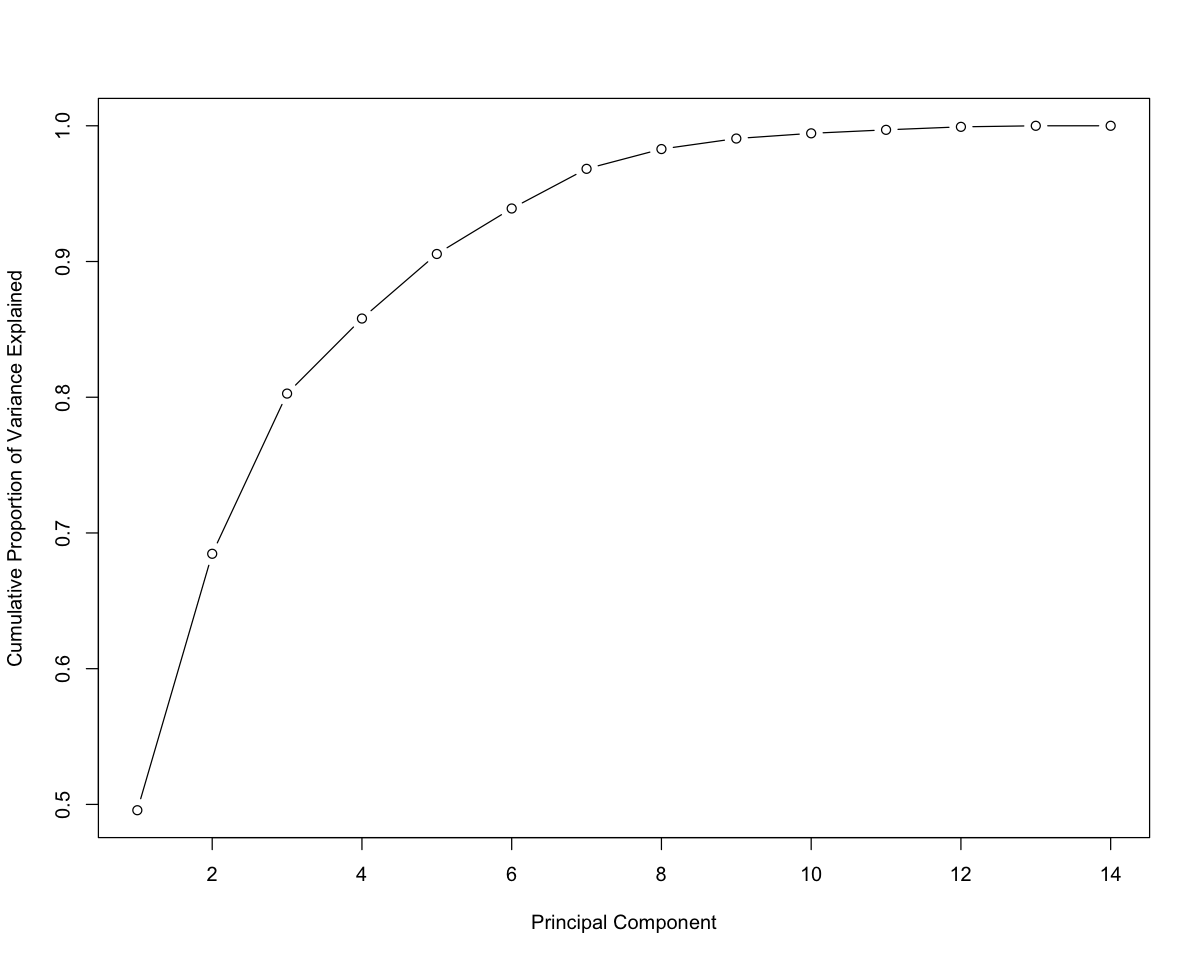

In [21]:
std_dev_prin_comp <- prin_comp$sdev
pr_var_prin_comp <- std_dev_prin_comp^2
prop_varex <- pr_var_prin_comp/sum(pr_var_prin_comp)
prop_varex
plot(cumsum(prop_varex), xlab = "Principal Component",
              ylab = "Cumulative Proportion of Variance Explained",
              type = "b")

#### Principal Component Regression
Nous allons utiliser comme variables indépendantes les 5 premières composantes du PCA. Nous allons utiliser le PCA pour faire une regression (PCR) et finalement nous allons comparer leurs MSE pour voir si on a pu ameliorer la prediction en utilisant le PCA.

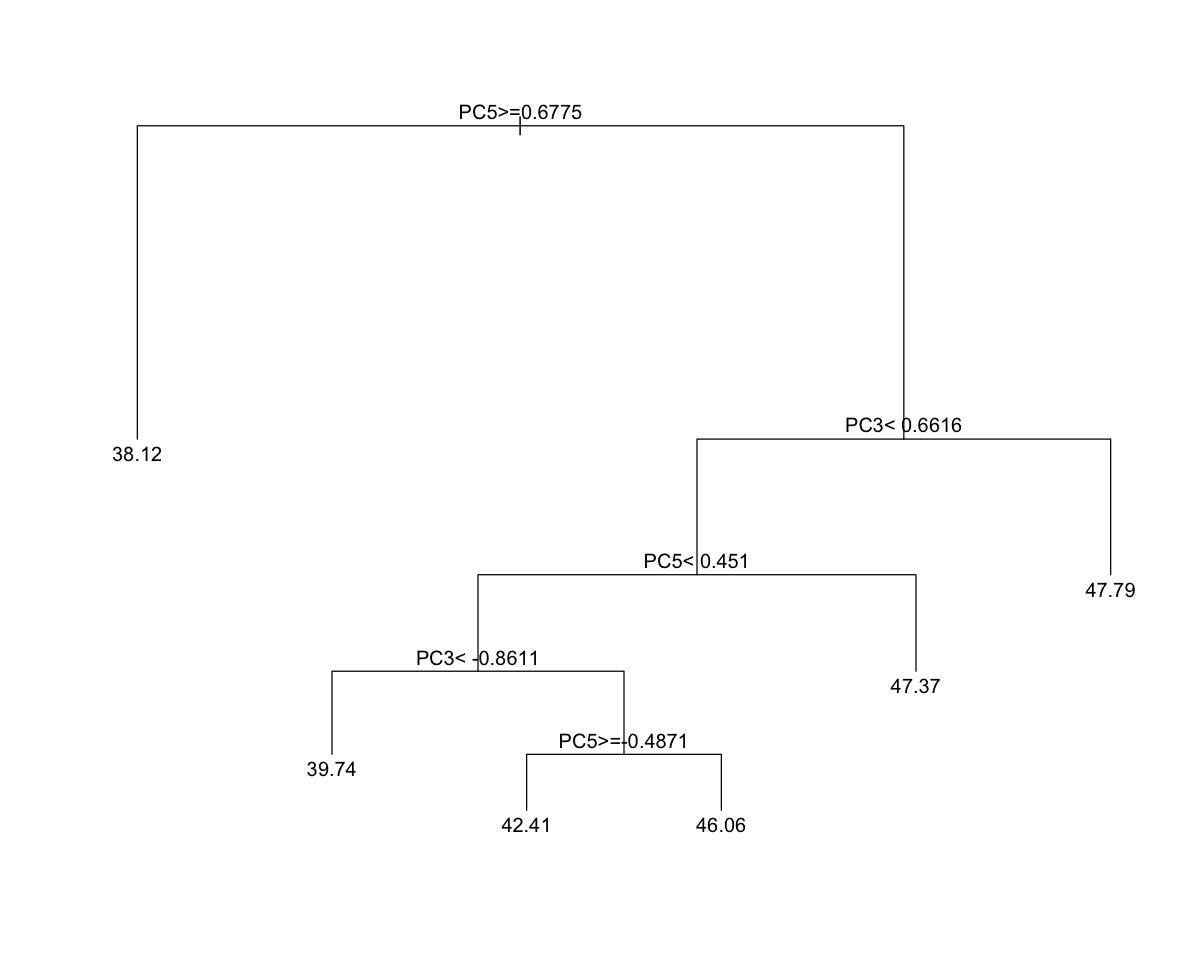

In [22]:
train.data = data.frame(y_train = dat.dep[train,"Choix.A.pc"],prin_comp$x)
train.data <- train.data[,1:6]
rpart.model <- rpart(y_train ~ .,data = train.data, method = "anova")
plot(rpart.model)
text(rpart.model)

In [23]:
test = dat.dep[-train,chosen_linear]
test.data = predict(prin_comp, newdata = test)
test.data <- as.data.frame(test.data)
test.data <- test.data[,1:5]
rpart.prediction <- predict(rpart.model, test.data)

In [24]:
data.frame("Test" = y_test, "Linear_prediction" = predicted_linear, 
           "Tree_prediction" = predicted_tree, "PCR_prediction" = rpart.prediction)
errors = data.frame("Error_Linear_prediction" = mse(y_test,predicted_linear),
                    "Error_Tree_prediction" = mse(y_test,predicted_tree),
                   "Erreur_PCR_prediction" = mse(y_test,rpart.prediction))
errors

Test     Linear_prediction Tree_prediction PCR_prediction
2  40.58347 43.92452          36.82211        39.74432      
5  44.03240 47.82838          39.79899        42.41190      
8  41.49657 38.61064          36.82211        38.11690      
10 33.75343 45.06042          44.74914        42.41190      
12 45.89875 45.90139          48.52961        46.06130      
13 41.19475 44.90876          45.75386        42.41190      
15 43.21688 40.84523          48.52961        42.41190      
21 39.80143 26.26052          48.52961        38.11690      
25 49.87250 44.83448          39.79899        46.06130      
28 38.67344 34.01904          36.82211        38.11690      
30 50.24015 46.69284          36.82211        39.74432      
33 47.94308 42.92745          48.52961        46.06130      
34 48.04520 47.39620          45.75386        47.79031      
36 47.17318 44.12224          49.03113        46.06130      
39 44.82403 39.78374          36.47171        42.41190      
40 41.56646 42.21948          39.79899        42.41190      
43 41.28843 42.96626          49.03113        42.41190      
46 38.45048 42.39581          39.79899        42.41190      
47 53.55308 43.50124          48.52961        47.79031      
50 40.94933 48.04464          49.03113        46.06130      
51 40.79261 36.65608          39.79899        42.41190      
52 35.92379 39.54578          45.75386        47.37169      
54 38.37857 43.61630          39.79899        39.74432      
58 37.91953 35.16181          45.75386        38.11690      
60 44.13737 44.19241          49.03113        39.74432      
61 38.52522 40.37024          45.75386        39.74432      
63 44.33361 49.08339          45.75386        39.74432      
74 40.21142 42.43486          36.47171        42.41190      
78 42.10248 41.24466          36.47171        38.11690      
80 47.92729 45.02218          39.79899        46.06130      
88 53.93895 55.55266          44.74914        46.06130      
91 41.45323 44.78766          45.75386        39.74432

Error_Linear_prediction Error_Tree_prediction Erreur_PCR_prediction
1 24.17845                40.00234              17.93744

## Peut-on faire plus d'analyses ?
Oui !
* *Pour compléter l'analyse actuelle*
    * Cross-validation : pour avoir une bonne estimation du vrai erreur de chaque modéle
    * Créer une variable géographique en utilisant un clustering des départements : nous observons visuellement une relation entre la position géographique et la quantité des voix pour Choix A ou B (et pour l'Abstentions et Blancs et nul). Nous pourrions faire une classification des départements par rapport à e.g. leur taux d'Abstentions et utiliser cette variable dans notre analyse predictive
    * Multivariate regression : on pourrait vouloir estimer aussi le porcentage de votes Blancs et nuls et donc avoir une estimation de nombre de voix par département. On peut essayer avec un Régression linéaire multiple (ou d'autres méthodes de régression multiple)
    

* *Pour avoir une analyse plus étendue*
    * Plus des variables : on a selectionné des variables réponse ét explicatives de manière arbitraire. On pourrait avoir des objectives plus précis pour déterminer les modèles à utiliser. E.g. nous voulons expliquer les taux d'abstentions par rapport aux variables sociodémographiques et voir l'influence des types et quantité des métiers
    * Nous avons choisi le niveau *département* pour faire l'analyse, mais nous avons aussi les données plus detaillées des communes. Nous pourrios faire des comparaisons entre modèles à differents niveaux.
    * Plus des modéles : d'autres modéles de regression ? 